In [1]:
from attention import AttentionLayer

In [2]:
import numpy as np
import pandas as pd
import re
import nltk
nltk.download('stopwords')

from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
data=pd.read_csv("Reviews.csv",nrows=3000)
data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."
...,...,...,...,...,...,...,...,...,...,...
2995,2996,B0009JI7O8,A3KLEQQVY1I46S,Spence,2,2,4,1344297600,Color Discrepancy,"My primary reason for ordering, was the picture had shown the cookies as green. I will acknowledge that the ""Important Information"" heading listed a warning that the actual product may be differen..."
2996,2997,B0009JI7O8,A1WXEIP21U01ME,zazza,4,5,5,1297900800,crispy fresh,"The cookie is crispy good and flavorful. The fortunes are thoughtful, not the shallow ones we are seeing lately.(Be patient, even in time an egg will walk) I received the quantity and quality I ..."
2997,2998,B0009JI7O8,A7XPFLQYVPZAT,Kim Voong,1,1,2,1334361600,they are soooo tiny!,I was expecting these cookies were going to be normal size but i was wrong! i was planning on dipping them in chocolates but they r not those average size at all! So disappointed! I now have to g...
2998,2999,B0009JI7O8,A3ADANTR6G4LPB,Marjory Warrington,1,1,5,1323129600,Excellent service and product,"I ordered these fortune cookies as rewards for my students each time they passed a multiplication test (to go along with the theme ""Fortunately we know our math facts""). The majority of the cooki..."


In [4]:
data.drop_duplicates(subset=['Text'],inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)   #dropping na
data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."
...,...,...,...,...,...,...,...,...,...,...
2995,2996,B0009JI7O8,A3KLEQQVY1I46S,Spence,2,2,4,1344297600,Color Discrepancy,"My primary reason for ordering, was the picture had shown the cookies as green. I will acknowledge that the ""Important Information"" heading listed a warning that the actual product may be differen..."
2996,2997,B0009JI7O8,A1WXEIP21U01ME,zazza,4,5,5,1297900800,crispy fresh,"The cookie is crispy good and flavorful. The fortunes are thoughtful, not the shallow ones we are seeing lately.(Be patient, even in time an egg will walk) I received the quantity and quality I ..."
2997,2998,B0009JI7O8,A7XPFLQYVPZAT,Kim Voong,1,1,2,1334361600,they are soooo tiny!,I was expecting these cookies were going to be normal size but i was wrong! i was planning on dipping them in chocolates but they r not those average size at all! So disappointed! I now have to g...
2998,2999,B0009JI7O8,A3ADANTR6G4LPB,Marjory Warrington,1,1,5,1323129600,Excellent service and product,"I ordered these fortune cookies as rewards for my students each time they passed a multiplication test (to go along with the theme ""Fortunately we know our math facts""). The majority of the cooki..."


Preprocessing

Performing basic preprocessing steps is very important before we get to the model building part. Using messy and uncleaned
text data is a potentially disastrous move. So in this step, we will drop all the unwanted symbols, characters, etc. from
the text that do not affect the objective of our problem.

Here is the dictionary that we will use for expanding the contractions:

In [5]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

a) Text Cleaning

Let’s look at the first 10 reviews in our dataset to get an idea of the text preprocessing steps:

In [6]:
data['Text'][:10]


0    I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1             Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
2    This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...
3    If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The fl...
4                                                               Great taffy at a great price.  There was a wide assortment of yummy taffy.  Delivery was very quick.  If your a taff

#






#


We will perform the below preprocessing tasks for our data:

Convert everything to lowercase

Remove HTML tags

Contraction mapping

Remove (‘s)

Remove any text inside the parenthesis ( )

Eliminate punctuations and special characters

Remove stopwords

Remove short words

In [7]:
stop_words = set(stopwords.words('english'))
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

b) Summary Cleaning


And now we’ll look at the first 10 rows of the reviews to an idea of the preprocessing steps for the summary column:

In [8]:
data['Summary'][:10]


0                            Good Quality Dog Food
1                                Not as Advertised
2                            "Delight" says it all
3                                   Cough Medicine
4                                      Great taffy
5                                       Nice Taffy
6    Great!  Just as good as the expensive brands!
7                           Wonderful, tasty taffy
8                                       Yay Barley
9                                 Healthy Dog Food
Name: Summary, dtype: object

#





Define the function for this task:

In [9]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:
            newString=newString+i+' '
    return newString

#Call the above function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

Remember to add the START and END special tokens at the beginning and end of the summary:

In [10]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

In [11]:

for i in range(5):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: _START_ good quality dog food  _END_


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: _START_ not as advertised  _END_


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: _START_ delight says it all  _END_


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: _START_ cough medicine  _END_


Review: great taffy great price wide assortment yummy taffy delivery quick taffy lo

#




Understanding the distribution of the sequences

Here, we will analyze the length of the reviews and the summary to get an overall idea about the distribution of length of the text. This will help us fix the maximum length of the sequence:

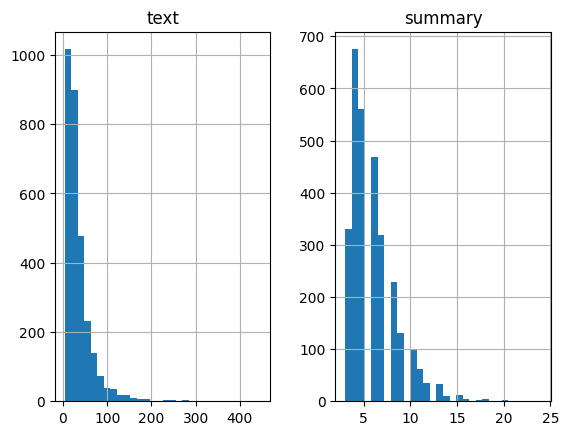

In [12]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

We can fix the maximum length of the reviews to 80 since that seems to be the majority review length. Similarly, we can set the maximum summary length to 10:

In [13]:
max_len_text=100
max_len_summary=50

we need to split our dataset into a training and validation set. We’ll use 90% of the dataset as the training data and evaluate the performance on the remaining 10% (holdout set):

In [14]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True)


Preparing the Tokenizer

A tokenizer builds the vocabulary and converts a word sequence to an integer sequence. Go ahead and build tokenizers for text and summary:

a) Text Tokenizer

In [15]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr)
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post')
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

b) Summary Tokenizer

In [16]:
#preparing a tokenizer for summary on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr)
y_val   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [17]:
pip install sentencepiece

In [18]:
pip install transformers


In [19]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load pre-trained T5 model and tokenizer
model_name = 't5-small'
model = T5ForConditionalGeneration.from_pretrained(model_name)
tokenizer = T5Tokenizer.from_pretrained(model_name)
# Convert cleaned_text and cleaned_summary into appropriate format for T5
input_texts = ['summarize: ' + text for text in data['cleaned_text']]
target_texts = data['cleaned_summary']

# Tokenize the input and target sequences using the tokenizer object
input_encodings = tokenizer.batch_encode_plus(input_texts, padding=True, truncation=True, return_tensors='pt')
target_encodings = tokenizer.batch_encode_plus(target_texts, padding=True, truncation=True, return_tensors='pt')

# Extract input_ids and attention_mask from encodings
input_ids = input_encodings['input_ids']
input_attention_mask = input_encodings['attention_mask']
target_ids = target_encodings['input_ids']
target_attention_mask = target_encodings['attention_mask']

You are using the legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565


In [20]:
# Create a DataLoader for batching
batch_size = 32
train_data = TensorDataset(input_ids, input_attention_mask, target_ids, target_attention_mask)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()



In [21]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_input_ids, batch_input_attention_mask, batch_target_ids, batch_target_attention_mask in train_loader:
      optimizer.zero_grad()


    # Forward pass
    outputs = model(input_ids=batch_input_ids, attention_mask=batch_input_attention_mask, labels=batch_target_ids)
    loss = outputs.loss

    # Backpropagation and optimization
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

avg_loss = total_loss / len(train_loader)
print(f"Epoch [{epoch+1}/{num_epochs}] - Avg Loss: {avg_loss:.4f}")






Epoch [5/5] - Avg Loss: 0.0272


In [22]:
# Generate summaries using the trained model
def generate_summary(text):
    input_seq = 'summarize: ' + text
    input_id = tokenizer.encode(input_seq, return_tensors='pt', max_length=max_len_text, truncation=True)
    summary_ids = model.generate(input_id, max_length=max_len_summary, num_beams=4, length_penalty=2.0, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary


In [23]:
# # Example usage
# for i in range(5):
#     original_text = data['cleaned_text'][i]
#     generated_summary = generate_summary(original_text)
#     # print("Original Text:", original_text)
#     # print("Generated Summary:", generated_summary)
#     # print("\n")

In [25]:

original_text = "A birthday is the anniversary of the birth of a person. It's a special day that celebrates the individual's life and the passage of another year. People often mark their birthdays with various traditions and celebrations, which can include parties, gatherings with friends and family, giving and receiving gifts, and enjoying special meals or treats."
generated_summary = generate_summary(original_text)
print("Original Text:", original_text)
print("Generated Summary:", generated_summary)
print("\n")

Original Text: A birthday is the anniversary of the birth of a person. It's a special day that celebrates the individual's life and the passage of another year. People often mark their birthdays with various traditions and celebrations, which can include parties, gatherings with friends and family, giving and receiving gifts, and enjoying special meals or treats.
Generated Summary: a birthday is the anniversary of the birth of a person.




In [26]:
pip install rouge-score


In [27]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from rouge_score import rouge_scorer

# Example reference summaries for evaluation
reference_summaries = [
    "good quality dog food",
    "small-sized unsalted peanuts",
    "delicious citrus gelatin treat",
    "root beer extract for soda",
    "wide assortment of yummy taffy"
]

generated_summaries = [
    "canned dog food products found good quality product looks",
    "product labeled jumbo salted",
    "robitussin believe found a",
    "great taffy delivery quick t",
    "yummy treat familiar story lewis lion witch wardrobe"
]

# Compute BLEU score (same as before)
def compute_bleu(reference, candidate):
    reference = [reference.split()]
    candidate = candidate.split()
    smoothie = SmoothingFunction().method1
    bleu_score = sentence_bleu(reference, candidate, smoothing_function=smoothie)
    return bleu_score

# Compute ROUGE scores using rouge-score library
def compute_rouge(reference, candidate):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, candidate)
    return scores

# Compute BLEU and ROUGE scores for all generated summaries
for i in range(len(reference_summaries)):
    ref_summary = reference_summaries[i]
    gen_summary = generated_summaries[i]

    bleu_score = compute_bleu(ref_summary, gen_summary)
    rouge_scores = compute_rouge(ref_summary, gen_summary)

    print(f"Reference Summary: {ref_summary}")
    print(f"Generated Summary: {gen_summary}")
    print(f"BLEU Score: {bleu_score:.4f}")
    print(f"ROUGE-1: {rouge_scores['rouge1'].precision:.4f}, {rouge_scores['rouge1'].recall:.4f}, {rouge_scores['rouge1'].fmeasure:.4f}")
    print(f"ROUGE-2: {rouge_scores['rouge2'].precision:.4f}, {rouge_scores['rouge2'].recall:.4f}, {rouge_scores['rouge2'].fmeasure:.4f}")
    print(f"ROUGE-L: {rouge_scores['rougeL'].precision:.4f}, {rouge_scores['rougeL'].recall:.4f}, {rouge_scores['rougeL'].fmeasure:.4f}")
    print("\n")


Reference Summary: good quality dog food
Generated Summary: canned dog food products found good quality product looks
BLEU Score: 0.0717
ROUGE-1: 0.4444, 1.0000, 0.6154
ROUGE-2: 0.2500, 0.6667, 0.3636
ROUGE-L: 0.2222, 0.5000, 0.3077


Reference Summary: small-sized unsalted peanuts
Generated Summary: product labeled jumbo salted
BLEU Score: 0.0000
ROUGE-1: 0.0000, 0.0000, 0.0000
ROUGE-2: 0.0000, 0.0000, 0.0000
ROUGE-L: 0.0000, 0.0000, 0.0000


Reference Summary: delicious citrus gelatin treat
Generated Summary: robitussin believe found a
BLEU Score: 0.0000
ROUGE-1: 0.0000, 0.0000, 0.0000
ROUGE-2: 0.0000, 0.0000, 0.0000
ROUGE-L: 0.0000, 0.0000, 0.0000


Reference Summary: root beer extract for soda
Generated Summary: great taffy delivery quick t
BLEU Score: 0.0000
ROUGE-1: 0.0000, 0.0000, 0.0000
ROUGE-2: 0.0000, 0.0000, 0.0000
ROUGE-L: 0.0000, 0.0000, 0.0000


Reference Summary: wide assortment of yummy taffy
Generated Summary: yummy treat familiar story lewis lion witch wardrobe
BLEU S

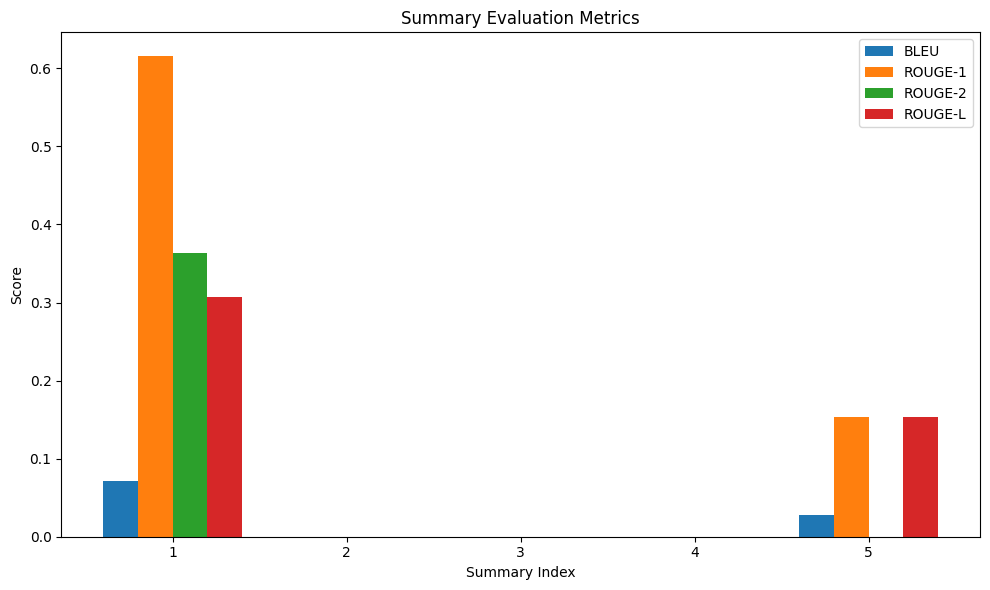

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# ... (previous code)

# Lists to store scores for plotting
bleu_scores_list = []
rouge1_f1_scores_list = []
rouge2_f1_scores_list = []
rougeL_f1_scores_list = []

# Compute scores and populate the lists
for i in range(len(reference_summaries)):
    ref_summary = reference_summaries[i]
    gen_summary = generated_summaries[i]

    bleu_score = compute_bleu(ref_summary, gen_summary)
    rouge_scores = compute_rouge(ref_summary, gen_summary)

    bleu_scores_list.append(bleu_score)
    rouge1_f1_scores_list.append(rouge_scores['rouge1'].fmeasure)
    rouge2_f1_scores_list.append(rouge_scores['rouge2'].fmeasure)
    rougeL_f1_scores_list.append(rouge_scores['rougeL'].fmeasure)

# Summary indices
summary_indices = np.arange(len(reference_summaries))

# Bar width
bar_width = 0.2

# Create subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the scores
ax.bar(summary_indices, bleu_scores_list, bar_width, label='BLEU')
ax.bar(summary_indices + bar_width, rouge1_f1_scores_list, bar_width, label='ROUGE-1')
ax.bar(summary_indices + 2 * bar_width, rouge2_f1_scores_list, bar_width, label='ROUGE-2')
ax.bar(summary_indices + 3 * bar_width, rougeL_f1_scores_list, bar_width, label='ROUGE-L')

ax.set_xlabel('Summary Index')
ax.set_ylabel('Score')
ax.set_title('Summary Evaluation Metrics')
ax.set_xticks(summary_indices + 1.5 * bar_width)
ax.set_xticklabels(summary_indices + 1)  # 1-indexed summary index
ax.legend()

plt.tight_layout()
plt.show()
